In [1]:
import torch#, torchvision, torchmetrics
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import torch_geometric
import random

import os
os.environ['TORCH'] = torch.__version__
print('PyTorch version : ', torch.__version__)
print('PyTorch Geometric version : ', torch_geometric.__version__)

PyTorch version :  2.3.1
PyTorch Geometric version :  2.5.3


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf', 'png')
from matplotlib.colors import to_rgb
import seaborn as sns
sns.reset_orig()
sns.set()
import networkx as nx

In [3]:
#from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx

In [4]:

def visualize_graph(G, color='blue'):
    
    G = to_networkx(G)
    plt.figure(figsize=(8,5))
    plt.xticks([])
    plt.yticks([])
    
    #fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.subplot(2, 2, 1)
    
    adjacency_matrix = nx.to_numpy_array(G, nodelist=G.nodes() )
    
    print('adjacency_matrix : ', adjacency_matrix)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    
    plt.subplot(2, 2, 2)
    
    plt.imshow(adjacency_matrix,
                  #cmap="Greys",
                  #interpolation="none"
                  )
    
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

## Set the seeds once & for all for reproducibility

In [5]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

## We will use **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)** package for learning GNN

In [6]:
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx

### Graph representation

Before starting the discussion of specific neural network operations on graphs, we should consider how to represent a graph. Mathematically, a graph $\mathcal{G}$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges/links $E$: $\mathcal{G}=(V,E)$. Each edge is a pair of two vertices, and represents a connection between them. For instance, let's look at the following graph:


The vertices are $V=\{1,2,3,4\}$, and edges $E=\{(1,2), (2,1), (2,3), (3,4)\}$. Note that for simplicity, we assume the graph to be undirected and hence don't add mirrored pairs like $(2,1)$. In application, vertices and edge can often have specific attributes, and edges can even be directed. The question is how we could represent this diversity in an efficient way for matrix operations. Usually, for the edges, we decide between two variants: an adjacency matrix, or a list of paired vertex indices. 

Here we have to define the graph dataset. We do this in a separate class following this example: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html#creating-larger-datasets

Formally, a graph is represented by a triplet $\mathcal G = (\mathbf{u}, V, E)$, consisting of a graph-level, or *global*, feature vector $\mathbf{u}$, a set of $N^v$ nodes $V$, and a set of $N^e$ edges $E$.
The nodes are given by $V = \{\mathbf{v}_i\}_{i=1:N^v}$, where $\mathbf{v}_i$ represents the $i$th node's attributes.
The edges connect pairs of nodes and are given by $E = \{\left(\mathbf{e}_k, r_k, s_k\right)\}_{k=1:N^e}$, where $\mathbf{e}_k$ represents the $k$th edge's attributes, and $r_k$ and $s_k$ are the indices of the "receiver" and 
"sender" nodes, respectively, connected by the $k$th edge (from the sender node to the receiver node).
The receiver and sender index vectors are an alternative way of encoding the directed adjacency matrix.

<img src="https://github.com/jmduarte/capstone-particle-physics-domain/raw/master/weeks/attributes.png" alt="attributes" width="500">

In [7]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 3]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1], [2]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [8]:
data = Data(x=x, edge_index=edge_index.contiguous())
data

Data(x=[4, 1], edge_index=[2, 4])

adjacency_matrix :  [[0. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


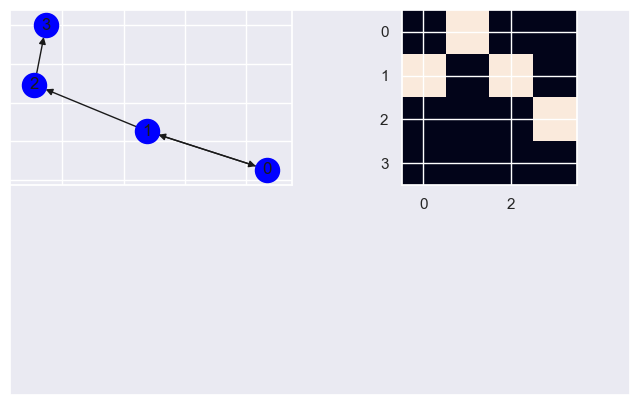

In [9]:
visualize_graph(data)

In [10]:
data.has_self_loops()

False

In [11]:
from torch_geometric.utils import add_self_loops, remove_self_loops, remove_isolated_nodes, add_remaining_self_loops, degree
from torch_geometric.utils import from_networkx

## Let's add bunch of self loops

In [12]:
edge_index = torch.tensor([[0, 0, 1, 1, 2, 3],
                           [0, 1, 0, 2, 3, 3]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1], [2]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

adjacency_matrix :  [[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


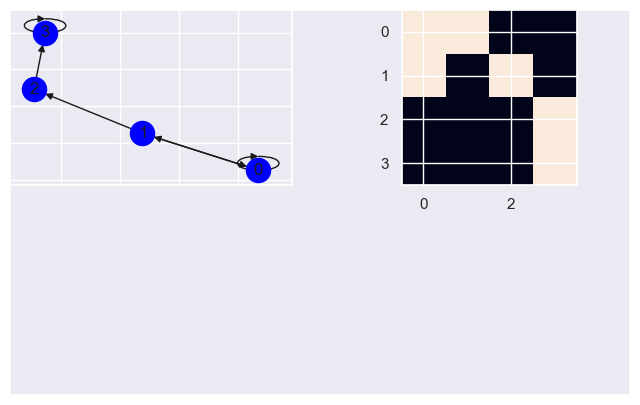

In [13]:
visualize_graph(data)

In [14]:
new_edge_index,_ = remove_self_loops(data.edge_index) ## what's the _ doing ?
data_n = Data(x=x, edge_index=new_edge_index.long())

adjacency_matrix :  [[0. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


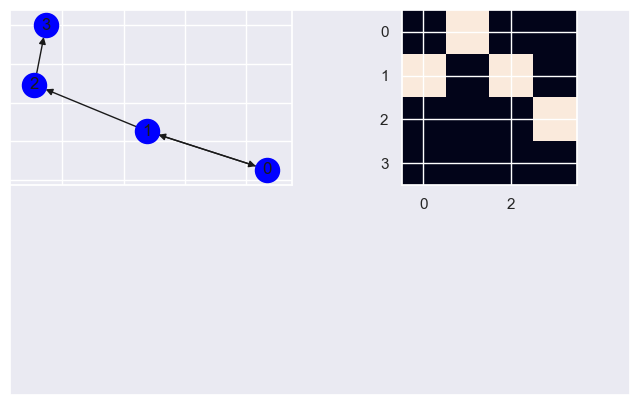

In [15]:
visualize_graph(data_n)

In [16]:
new_edge_index[0].long()

tensor([0, 1, 1, 2])

### Some readily available attributes of PyG Data class

In [17]:
data.num_nodes, data.num_edges, data.num_node_features, data.num_edge_features

(4, 6, 1, 0)

In [18]:
if(torch.backends.cuda.is_built()) : 
    device='cuda'
elif(torch.backends.mps.is_built()) : 
    device='mps'
else : 
    device='cpu'

In [19]:
data = data.to(device=device)

In [20]:
data.x.device

device(type='mps', index=0)

In [21]:
data_n.edge_index.T, data_n.num_nodes

(tensor([[0, 1],
         [1, 0],
         [1, 2],
         [2, 3]]),
 4)

### Number of in_degrees and out_degrees of a node

In [22]:

adjacency_matrix = nx.to_numpy_array(to_networkx(data_n), nodelist=to_networkx(data_n).nodes() )
plt.imshow(adjacency_matrix)

In [23]:
deg = degree(data.edge_index[0], data.num_nodes)
deg

tensor([2., 2., 1., 1.], device='mps:0')

In [24]:
adjacency_matrixT = torch.Tensor(adjacency_matrix)
adjacency_matrixT

tensor([[0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])

In [25]:
num_neighbours = adjacency_matrixT.sum(dim=0, keepdims=True)
num_neighbours

tensor([[1., 1., 1., 1.]])

### How many nodes to which a particular node can receive and send information?

In [26]:
degree_in, degree_out = adjacency_matrixT.sum(dim=0, keepdims=True), adjacency_matrixT.sum(dim=-1, keepdims=True)
degree_in, degree_out, data_n.edge_index.shape

(tensor([[1., 1., 1., 1.]]),
 tensor([[1.],
         [2.],
         [1.],
         [0.]]),
 torch.Size([2, 4]))

In [27]:
data.keys

<bound method BaseData.keys of Data(x=[4, 1], edge_index=[2, 6])>

# Minibatching, Unbatching, standard datasets, subgraphs(nodes, edges)

### What does it mean to batch few graphs?

<img src="mini_batch_graph.png" alt="Alternative text" />

In [28]:
data1, data2 = from_networkx(nx.cycle_graph(3)), from_networkx(nx.wheel_graph(4))

adjacency_matrix :  [[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


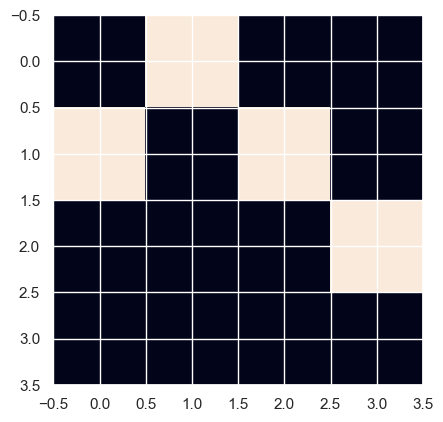

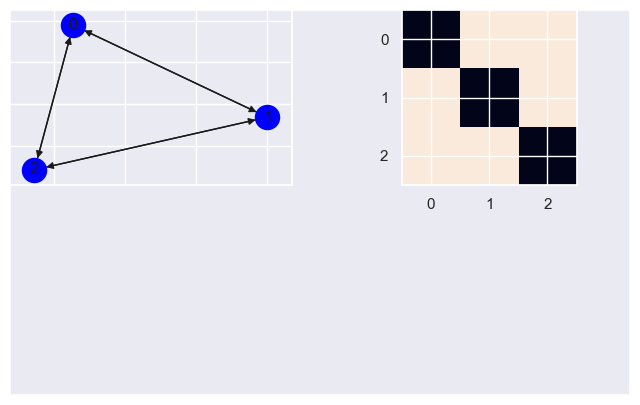

adjacency_matrix :  [[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


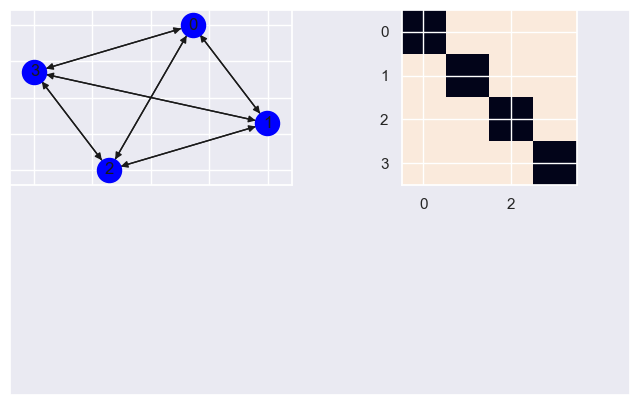

(None, None)

In [29]:
visualize_graph(data1), visualize_graph(data2)

adjacency_matrix :  [[0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


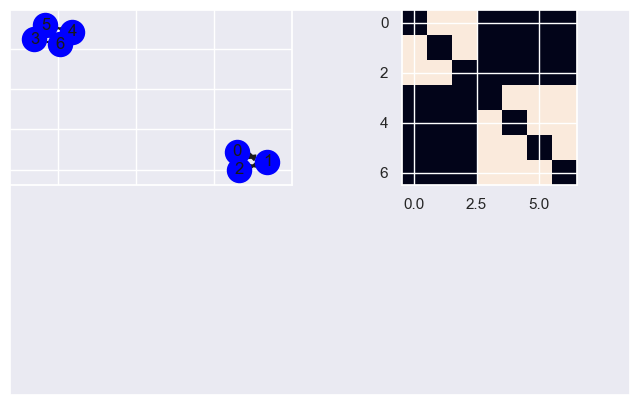

DataBatch(edge_index=[2, 18], num_nodes=7, batch=[7], ptr=[3])

In [30]:
graph_b = torch_geometric.data.Batch.from_data_list([data1, data2])
visualize_graph(graph_b)
graph_b

In [31]:
torch_geometric.data.Batch.to_data_list(graph_b)

[Data(edge_index=[2, 6], num_nodes=3), Data(edge_index=[2, 12], num_nodes=4)]

In [32]:
data2.subgraph(subset = torch.tensor([0, 1]).long())

Data(edge_index=[2, 2], num_nodes=2)

adjacency_matrix :  [[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


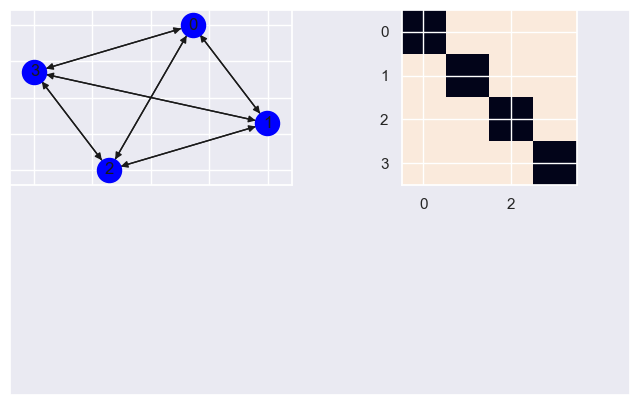

adjacency_matrix :  [[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


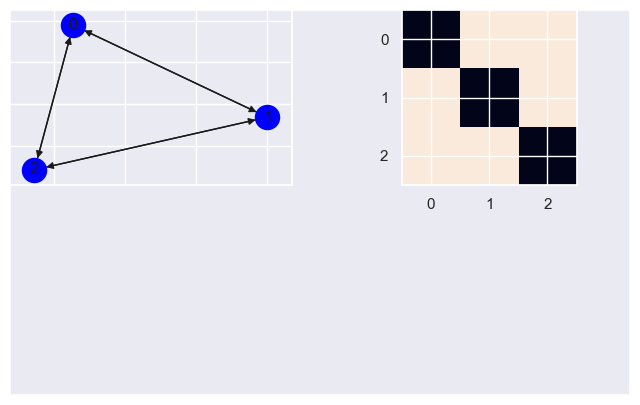

(None, None)

In [33]:
visualize_graph(data2), visualize_graph(data2.subgraph(subset = torch.tensor([0, 1, 2]).long()))

In [34]:
AdjMat = torch.ones([3,3]) - torch.zeros([3,3]).fill_diagonal_(1)
AdjMat

tensor([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])

In [35]:
tree = nx.balanced_tree(r=2, h=3)
nx.draw_networkx(tree, pos=nx.spring_layout(tree, seed=42), with_labels=True,
                     node_color='red', cmap="Set2")

/Users/sanmay/miniconda3/envs/work_env/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


adjacency_matrix :  [[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


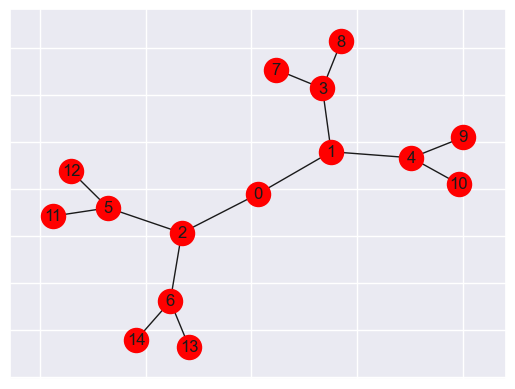

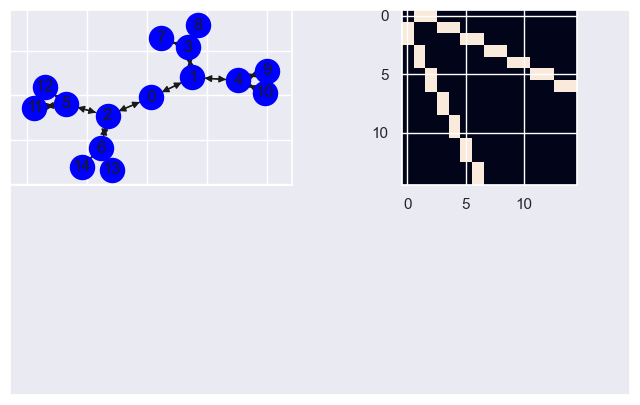

In [36]:
visualize_graph(from_networkx(tree))

In [37]:
gr = from_networkx(tree)
gr.is_directed()

False

In [38]:
gr.edge_index

tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,
          6,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 1,  2,  0,  3,  4,  0,  5,  6,  1,  7,  8,  1,  9, 10,  2, 11, 12,  2,
         13, 14,  3,  3,  4,  4,  5,  5,  6,  6]])

## Introduction to message passing 

In [39]:
from torch_geometric.nn import MessagePassing


In [40]:
class MyMPLayer(MessagePassing):
    def __init__(self):
        super().__init__(aggr="add")

    def forward(self, x, edge_index):
        return self.propagate(edge_index=edge_index, x=x)

    def message(self, x_i, x_j):
        return ( x_i + x_j/2)

In [45]:
layer = MyMPLayer()

In [46]:
x = torch.zeros([gr.num_nodes, 1])
x[0] = torch.tensor([2**4])
gr.x = x

In [47]:
gr.x

tensor([[16.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]])

In [48]:
def draw_graph_color(G, iter=0) : 
    
    x = G.x
    G = to_networkx(G)
    
    color_lookup = {v:int(k.item()) for v, k in enumerate(x)}
    #color_label = {v:str(k.item()) for v, k in enumerate(x)}
    
    low, *_, high = sorted(color_lookup.values())
    
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm) 
    
    nx.draw(G, 
        nodelist=color_lookup,
        pos=nx.spring_layout(tree, seed=42),
        node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], 
        #label=color_label,
        with_labels=True)
    
    plt.text(0.1, 0.9, 'iter : ' + str(iter))
    plt.show()
    
    
    
    
    
    
    
    

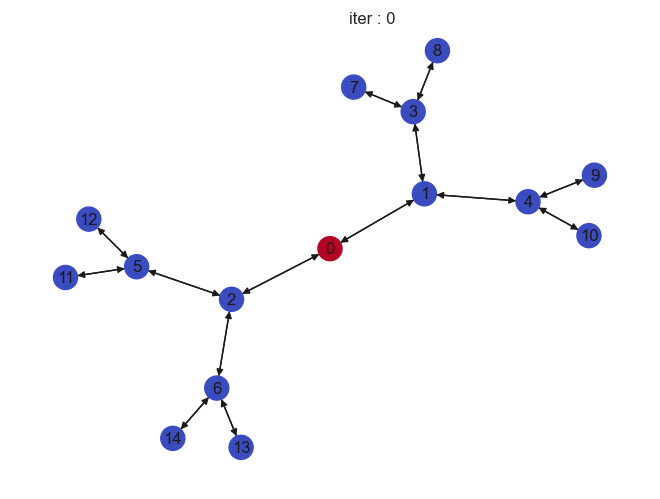

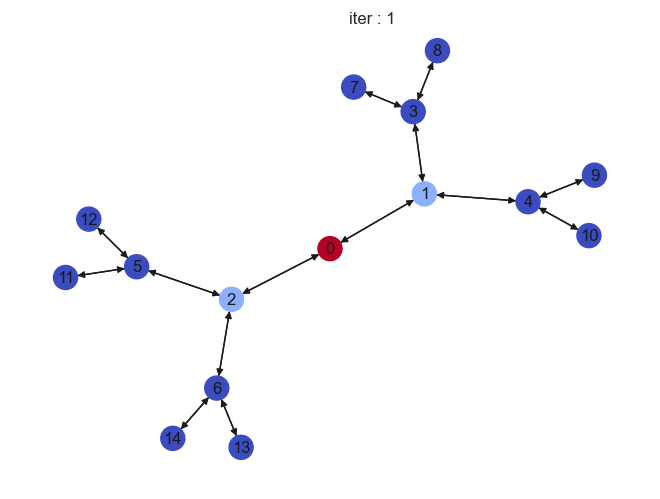

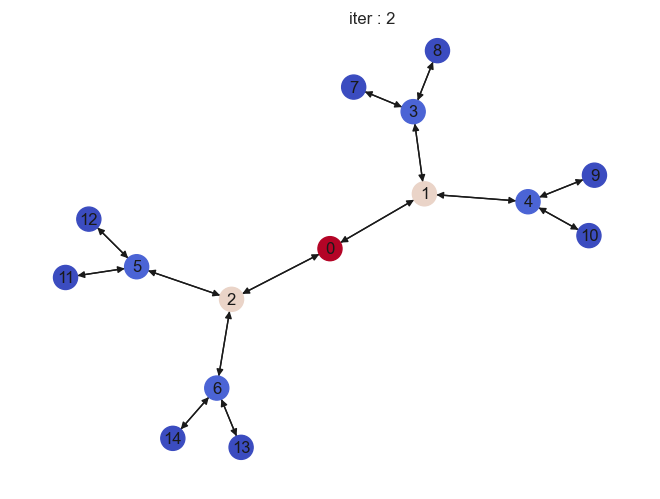

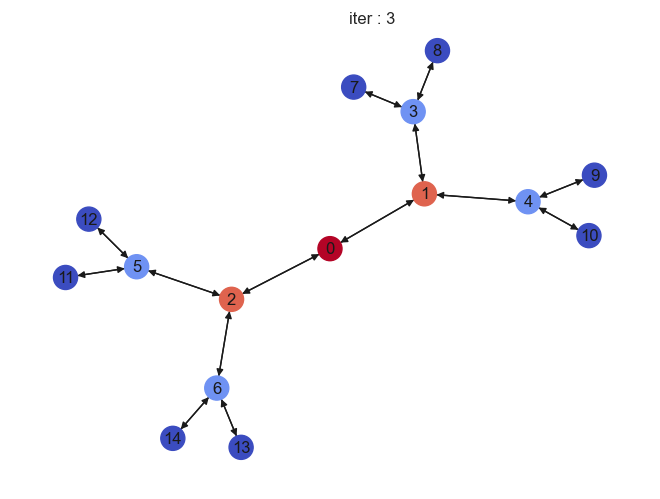

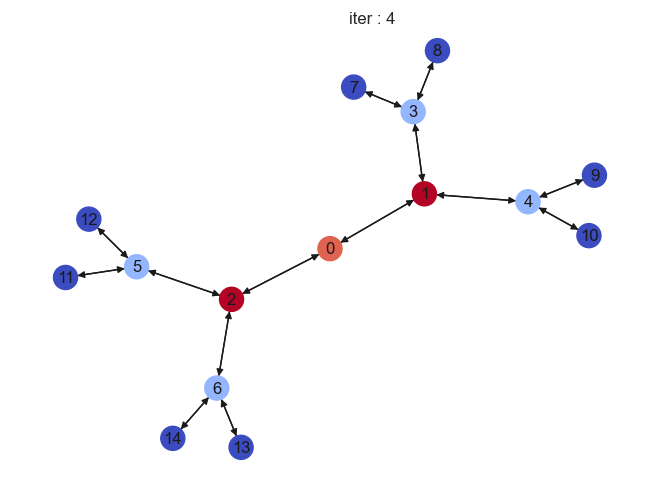

In [49]:
draw_graph_color(gr)
for idx in range(4) : 
    
    out = layer(x=gr.x, edge_index=gr.edge_index)
    gr.x = out
    draw_graph_color(gr, idx+1)

In [50]:
#layer = MyMPLayer()

In [51]:
src_index = gr.edge_index[0]

In [54]:
#tmp = torch.index_select(src, 0, src_index) 

In [55]:
tree.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))

In [56]:
#color_lookup = {v:int(k.item()) for v, k in enumerate(sorted(set(x)))}
color_lookup = {v:int(k.item()) for v, k in enumerate(x)}

In [57]:
color_lookup

{0: 16,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0}

In [58]:
low, *_, high = sorted(color_lookup.values())

In [59]:
low, high

(0, 16)

## What is a message passing network?

Here, we recapitulate the "graph network" (GN) formalism {cite:p}`battaglia2018relational`, which generalizes various GNNs and other similar methods.
GNs are graph-to-graph mappings, whose output graphs have the same node and edge structure as the input. 
Formally, a GN block contains three "update" functions, $\phi$, and three "aggregation" functions, $\rho$.
The stages of processing in a single GN block are:

<img src="GN-full-block.png" alt="Alternative text" />

where $E'_i = \left\{\left(\mathbf{e}'_k, r_k, s_k \right)\right\}_{r_k=i,\; k=1:N^e}$ contains the updated edge features for edges whose receiver node is the $i$th node, $E' = \bigcup_i E_i' = \left\{\left(\mathbf{e}'_k, r_k, s_k \right)\right\}_{k=1:N^e}$ is the set of updated edges, and $V'=\left\{\mathbf{v}'_i\right\}_{i=1:N^v}$ is the set of updated nodes.

